## 1. Package load

In [1]:
import torch
import torch.nn as nn
import torchvision.datasets as dset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
print('pytorch version: {}'.format(torch.__version__))
print('GPU 사용 가능 여부: {}'.format(torch.cuda.is_available()))
device = "cuda" if torch.cuda.is_available() else "cpu"   # GPU 사용 가능 여부에 따라 device 정보 저장

pytorch version: 1.5.0
GPU 사용 가능 여부: True


## 2. 하이퍼파라미터 세팅

In [3]:
# 미니배치의 크기(batch_size)
# 학습 할 세대(epoch) 수(num_epochs)
# 학습률(learning_rate)
batch_size = 100
num_epochs = 5
learning_rate = 0.001

## 3. Dataset 및 DataLoader 할당

In [4]:
from torch.utils.data import DataLoader

root = './data'
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=(0.5,), std=(0.5,))])
train_data = dset.FashionMNIST(root=root, train=True, transform=transform, download=True)
test_data = dset.FashionMNIST(root=root, train=False, transform=transform, download=True)

Extracting ./data\FashionMNIST\raw\train-images-idx3-ubyte.gz to ./data\FashionMNIST\raw


Extracting ./data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw


Extracting ./data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ./data\FashionMNIST\raw


Extracting ./data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw
Processing...


..\torch\csrc\utils\tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


Done!


In [5]:
train_loader = DataLoader(
        dataset = train_data,
        batch_size = batch_size,
        shuffle = True,
        drop_last = True
)
test_loader = DataLoader(
        dataset = test_data,
        batch_size = batch_size,
        shuffle = False,
        drop_last = True
)

## 4. 데이터 샘플 시각화

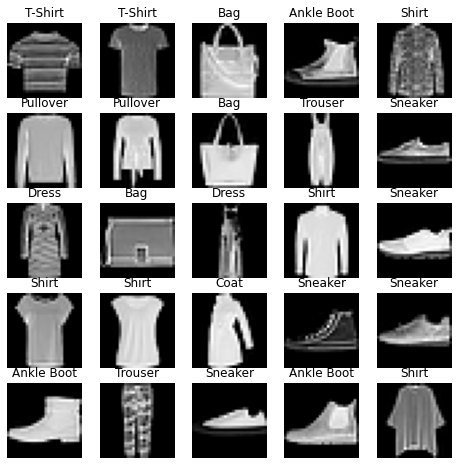

In [6]:
labels_map = {0 : 'T-Shirt', 1 : 'Trouser', 2 : 'Pullover', 3 : 'Dress', 4 : 'Coat', 5 : 'Sandal', 6 : 'Shirt',
              7 : 'Sneaker', 8 : 'Bag', 9 : 'Ankle Boot'}
columns = 5
rows = 5
fig = plt.figure(figsize=(8,8))

for i in range(1, columns*rows+1):
    data_idx = np.random.randint(len(train_data))
    img = train_data[data_idx][0][0,:,:].numpy() # numpy()를 통해 torch Tensor를 numpy array로 변환
    label = labels_map[train_data[data_idx][1]] # item()을 통해 torch Tensor를 숫자로 변환
    
    fig.add_subplot(rows, columns, i)
    plt.title(label)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
plt.show()

## 5. 네트워크 설계

In [7]:
class DNN(nn.Module):
    def __init__(self, num_classes=10):
        super(DNN, self).__init__() # 꼭 super 호출
        self.layer1 = nn.Sequential(
            
            nn.Linear(28*28, 512),   # Linear_1 해당하는 층
            nn.BatchNorm1d(512),    # BatchNorm_1 해당하는 층
            nn.ReLU()     # ReLU_1 해당하는 층
            
        )
        self.layer2 = nn.Sequential(
            
            nn.Linear(512, 10)    # Linear_2 해당하는 층 
            
        )
    
    def forward(self, x):
        x = x.view(x.size(0), -1) # flatten
        x_out = self.layer1(x)
        x_out = self.layer2(x_out)
        return x_out

## 6. Weight initialization

In [8]:
def weights_init(m):
    if isinstance(m, nn.Linear): # 모델의 모든 MLP 레이어에 대해서
        nn.init.xavier_normal_(m.weight) # Weight를 xavier_normal로 초기화
        print(m.weight)

## 7. 모델 생성

In [9]:
torch.manual_seed(7777) # 일관된 weight initialization을 위한 random seed 설정
model = DNN().to(device)
model.apply(weights_init) # 모델에 weight_init 함수를 적용하여 weight를 초기화

Parameter containing:
tensor([[-0.0113, -0.0095, -0.0257,  ..., -0.0324,  0.0534, -0.0091],
        [-0.0407,  0.0350, -0.0196,  ..., -0.0266,  0.0307,  0.0381],
        [-0.0205,  0.0367,  0.0094,  ..., -0.0310, -0.0451,  0.0051],
        ...,
        [ 0.0256,  0.0471,  0.0721,  ..., -0.0425, -0.0057,  0.1168],
        [ 0.0259, -0.0902,  0.0282,  ..., -0.0785, -0.0460, -0.0391],
        [ 0.0022, -0.0167,  0.0413,  ...,  0.0063,  0.0709, -0.0014]],
       device='cuda:0', requires_grad=True)
Parameter containing:
tensor([[ 0.0519,  0.0610, -0.0333,  ...,  0.0951,  0.0609,  0.0190],
        [-0.0366, -0.0194, -0.0457,  ..., -0.0288,  0.0835,  0.0015],
        [-0.0753, -0.0058, -0.0136,  ...,  0.0164,  0.0518, -0.0549],
        ...,
        [ 0.0794,  0.0515, -0.0347,  ...,  0.0125, -0.1136, -0.0632],
        [ 0.0133, -0.1174,  0.0302,  ..., -0.0633, -0.0538, -0.0551],
        [ 0.0272, -0.0225, -0.0094,  ...,  0.0671,  0.0514, -0.0534]],
       device='cuda:0', requires_grad=True)


DNN(
  (layer1): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer2): Sequential(
    (0): Linear(in_features=512, out_features=10, bias=True)
  )
)

## 8. Loss function 및 Optimizer 정의

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

## 9. Training

In [11]:
for epoch in range(num_epochs):
    for i, (imgs, labels) in enumerate(train_loader):
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        loss = criterion(outputs, labels)     
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        _, argmax = torch.max(outputs, 1)
        accuracy = (labels == argmax).float().mean()
        
        if (i+1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'.format(
                epoch+1, num_epochs, i+1, len(train_loader), loss.item(), accuracy.item() * 100))

Epoch [1/5], Step [100/600], Loss: 0.4614, Accuracy: 86.00%
Epoch [1/5], Step [200/600], Loss: 0.4722, Accuracy: 80.00%
Epoch [1/5], Step [300/600], Loss: 0.4135, Accuracy: 85.00%
Epoch [1/5], Step [400/600], Loss: 0.3718, Accuracy: 88.00%
Epoch [1/5], Step [500/600], Loss: 0.5568, Accuracy: 80.00%
Epoch [1/5], Step [600/600], Loss: 0.2790, Accuracy: 88.00%
Epoch [2/5], Step [100/600], Loss: 0.2765, Accuracy: 90.00%
Epoch [2/5], Step [200/600], Loss: 0.2878, Accuracy: 89.00%
Epoch [2/5], Step [300/600], Loss: 0.2124, Accuracy: 91.00%
Epoch [2/5], Step [400/600], Loss: 0.1925, Accuracy: 92.00%
Epoch [2/5], Step [500/600], Loss: 0.1935, Accuracy: 95.00%
Epoch [2/5], Step [600/600], Loss: 0.4067, Accuracy: 85.00%
Epoch [3/5], Step [100/600], Loss: 0.1787, Accuracy: 93.00%
Epoch [3/5], Step [200/600], Loss: 0.3354, Accuracy: 88.00%
Epoch [3/5], Step [300/600], Loss: 0.2453, Accuracy: 92.00%
Epoch [3/5], Step [400/600], Loss: 0.2521, Accuracy: 88.00%
Epoch [3/5], Step [500/600], Loss: 0.286

## 10. Test

In [12]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for i, (imgs, labels) in enumerate(test_loader):
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        _, argmax = torch.max(outputs, 1) # max()를 통해 최종 출력이 가장 높은 class 선택
        total += imgs.size(0)
        correct += (labels == argmax).sum().item()
    
    print('Test accuracy for {} images: {:.2f}%'.format(total, correct / total * 100))

Test accuracy for 10000 images: 87.26%


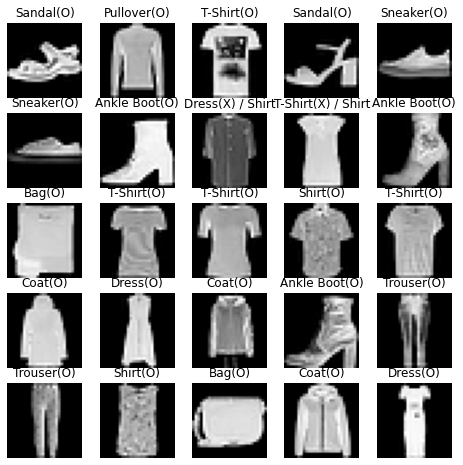

In [13]:
columns = 5
rows = 5
fig = plt.figure(figsize=(8,8))

model.eval()
for i in range(1, columns*rows+1):
    data_idx = np.random.randint(len(test_data))
    input_img = test_data[data_idx][0].unsqueeze(dim=0).to(device) 
    '''
    unsqueeze()를 통해 입력 이미지의 shape을 (1, 28, 28)에서 (1, 1, 28, 28)로 변환. 
    모델에 들어가는 입력 이미지의 shape은 (batch_size, channel, width, height) 되어야 함에 주의하세요!
    '''
    output = model(input_img)
    _, argmax = torch.max(output, 1)
    pred = labels_map[argmax.item()]
    label = labels_map[test_data[data_idx][1]]
    
    fig.add_subplot(rows, columns, i)
    if pred == label:
        plt.title(pred + '(O)')
    else:
        plt.title(pred + '(X)' + ' / ' + label)
    plot_img = test_data[data_idx][0][0,:,:]
    plt.imshow(plot_img, cmap='gray')
    plt.axis('off')
model.train()
plt.show()